# $\lambda$ Experiments


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import copy

In [3]:
import numpy as np

In [4]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [5]:
import matplotlib.pyplot as plt

In [10]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines, stochastic_hamming_loss, epsilon_greedy_predict_proba
from crm_dataset import CRMDataset
from crm_model import Model, EpsilonGreedyModel
from tracing_utils import LossHistory

---
### Loading dataset

In [7]:
# dataset_name='scene'
dataset_name='yeast'
# dataset_name='tmc2007'

X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name, reduce_dim=200)

reducing dimension for TMC dataset
X_train: (1812, 200) y_train: (1812, 14)


/home/e.diemert/miniconda/lib/python3.9/site-packages/sklearn/random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (104 < 200).The dimensionality of the problem will not be reduced.
  warnings.warn(


### Baselines & Skylines

In [9]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train, n_jobs=4)

# The Experiment

In [11]:
len(X_train)

1812

In [12]:
n_rollouts = 10

samples = [len(X_train)]
for _ in range(n_rollouts):
    samples += [int(samples[-1] / 2)]
samples = sorted([_ for _ in samples if _ > 100])

n_replays = 6  # actions per context
n_reruns = 10 # to account for action stochasticity
n_rollouts, samples

(10, [113, 226, 453, 906, 1812])

In [17]:
crm_losses = np.ones((n_reruns, len(samples)))
crm_rewards = np.ones((n_reruns, len(samples)))

test_sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T
crm_reward = CRMDataset().update_from_supervised_dataset(
    X_test, y_test, test_sampling_probas, n_samples=4
).rewards.sum() / (len(X_test)*y_test.shape[1]*4)

for i in range(n_reruns):
    np.random.seed(i*42+1000)
    print(i, end='')
    
    crm_model = EpsilonGreedyModel.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
        
    start = 0
    for j, end in enumerate(samples):
        print('.', end='')
        # current batch
        X = X_train[start:end, :]
        y = y_train[start:end, :]
        if end > start:
            # CRM play & data collection
            sampling_probas = epsilon_greedy_predict_proba(pi0, X, epsilon=.05) 
            crm_dataset.update_from_supervised_dataset(X, y, sampling_probas, n_samples=n_replays)
            # learning
            crm_model.fit(
                crm_dataset, 
                lambda_ = .5,
                verbose = 0
            )
        # eval
        crm_losses[i,j] = crm_model.expected_hamming_loss(X_test, y_test)
        crm_rewards[i,j] = crm_reward
        # next round
        start = end
    print()

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)
crm_losses, crm_rewards

0.....
1.....
2.....
3.....
4.....
5.....
6.....
7.....
8.....
9.....


(array([0.49916235, 0.43283887, 0.31170392, 0.30562909, 0.25967255]),
 array([0.59695986, 0.59695986, 0.59695986, 0.59695986, 0.59695986]))

In [23]:
scrm_losses = np.ones((n_reruns, len(samples)))
scrm_rewards = np.ones((n_reruns, len(samples)))
scrm_lambdas = np.ones((n_reruns, len(samples,)))

for i in range(n_reruns):
    np.random.seed(i*42+1000)
    print(i, end='')

    scrm_model = EpsilonGreedyModel.null_model(X_test.shape[1], y_test.shape[1])
    scrm_dataset = CRMDataset()
    
    start = 0
    for j, end in enumerate(samples):
        print('.', end='')
        # current batch
        X = X_train[start:end, :]
        y = y_train[start:end, :]
        if end > start:
            # CRM play & data collection
            if j == 0:
                sampling_probas = epsilon_greedy_predict_proba(pi0, X, epsilon=.05) 
            else:
                sampling_probas = scrm_model.predict_proba(X, y, randomize=True)
            scrm_dataset.update_from_supervised_dataset(X, y, sampling_probas, n_samples=n_replays)
            # bench lambdas
            best_lambda = -1 * np.sqrt(np.log(len(scrm_dataset))/len(scrm_dataset))
            # best_lambda = crm_model.cross_validate_lambda(
            #    scrm_dataset, 
            #    len(X_train)*n_replays, 
            #    grid=[1e-4, 1e-3, 1e-2, 1e-1, .5, 1],
            #    suffle=True,
            #    seed=i*42+1000+j, n_jobs=5
            # )
            scrm_lambdas[i,j] = best_lambda
            # learning
            scrm_model.fit(
                scrm_dataset, 
                lambda_ = best_lambda,
                verbose = 0
            )
        # eval
        scrm_losses[i,j] = scrm_model.expected_hamming_loss(X_test, y_test)
        scrm_rewards[i,j] = CRMDataset().update_from_supervised_dataset(
            X_test, y_test, scrm_model.predict_proba(X_test, np.ones_like(y_test)), n_samples=4
        ).rewards.sum()  / (len(X_test)*y_test.shape[1]*4)
        # next round
        start = end
    print()

scrm_losses = scrm_losses.mean(axis=0)
scrm_rewards = scrm_rewards.mean(axis=0)
#scrm_lambdas = scrm_lambdas.mean(axis=0)
scrm_losses, scrm_rewards, scrm_lambdas

0.....
1.....
2.....
3.....
4.....
5.....
6.....
7.....
8.....
9.....


(array([0.39007583, 0.40292183, 0.35634711, 0.34704157, 0.34533957]),
 array([0.60927391, 0.59714876, 0.64370425, 0.65298111, 0.65440083]),
 array([[-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784],
        [-0.09805744, -0.07293011, -0.05393852, -0.03977678, -0.02923784]]))

In [20]:
baseline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        epsilon_greedy_predict_proba(pi0, X_test, epsilon=.05), n_samples=4
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
for _ in range(10)])
baseline_rewards = np.ones_like(crm_losses)*baseline_reward

skyline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        epsilon_greedy_predict_proba(pistar, X_test, epsilon=.05), n_samples=4
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
for _ in range(10)])
skyline_rewards = np.ones_like(crm_losses)*skyline_reward

map_skyline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        pistar.predict(X_test), n_samples=1
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*1)
for _ in range(10)])
map_skyline_rewards = np.ones_like(crm_losses)*map_skyline_reward

baseline_loss = stochastic_hamming_loss(pi0, X_test, y_test)
skyline_loss = stochastic_hamming_loss(pistar, X_test, y_test)

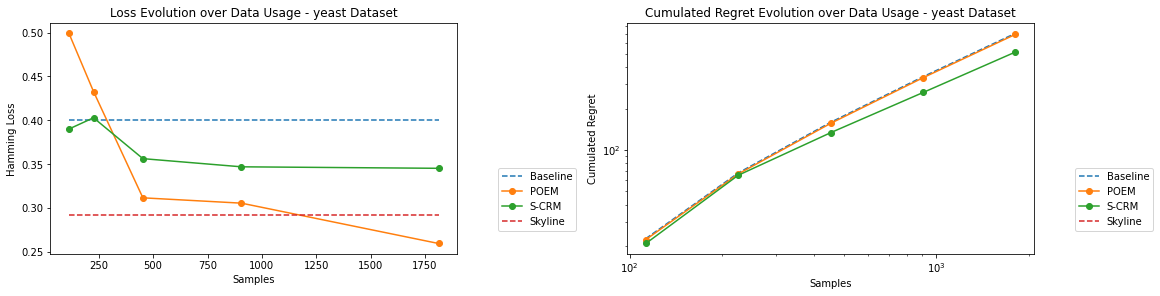

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(16,4))

ax1.set_title('Loss Evolution over Data Usage - %s Dataset' % dataset_name)
ax1.set_xlabel('Samples')
ax1.plot(samples, np.ones_like(crm_losses)*baseline_loss, '--', label='Baseline')
ax1.plot(samples, crm_losses, 'o-', label='POEM')
# ax1.plot(samples[1:], ucrm_losses, 'o-', label='POEM + Unif. Explo.')
ax1.plot(samples, scrm_losses, 'o-', label='S-CRM')
ax1.plot(samples, np.ones_like(crm_losses)*skyline_loss, '--', label='Skyline')
# ax1.plot(samples, np.ones_like(crm_losses)*map_skyline_loss, '--', label='Skyline (MAP)')
ax1.set_ylabel('Hamming Loss')
ax1.legend(loc=(1.1, .1))

ax2.set_title('Cumulated Regret Evolution over Data Usage - %s Dataset' % dataset_name)
ax2.set_xlabel('Samples')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(samples, np.cumsum(samples*map_skyline_rewards) - np.cumsum(samples*np.ones_like(crm_losses)*baseline_reward), '--', label='Baseline')
ax2.plot(samples, np.cumsum(samples*map_skyline_rewards) - np.cumsum(samples*crm_rewards), 'o-', label='POEM')
# ax2.plot(samples[1:], ucrm_rewards, 'o-', label='POEM + Unif. Explo.')
ax2.plot(samples, np.cumsum(samples*map_skyline_rewards) - np.cumsum(samples*scrm_rewards), 'o-', label='S-CRM')
ax2.plot(samples, np.zeros_like(samples*skyline_rewards), '--', label='Skyline')
ax2.set_ylabel('Cumulated Regret')
ax2.legend(loc=(1.1, .1))

Text(0, 0.5, '$\\lambda$')

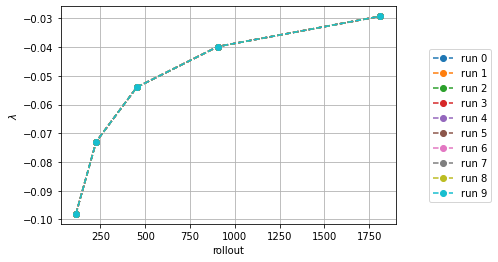

In [25]:
for j in range(scrm_lambdas.shape[0]):
    plt.plot(samples, scrm_lambdas[j, :], 'o--', label='run %d' % j)
plt.legend(loc=(1.1,.1))
plt.grid()
plt.xlabel('rollout')
#plt.yscale('log')
plt.ylabel('$\lambda$')